# Clasificación de imágenes de personas con mascarilla


## 1. Importación de librerías

In [2]:
# General
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

# Keras
import keras
from keras.src.utils import image_dataset_from_directory
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Input

from keras.models import Sequential, Model
from keras.utils import to_categorical

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

## 2. Creación de dataframe y partición en train y test


In [3]:
# Cargar datos de entrenamiento
train_dataset = image_dataset_from_directory(
    directory='./train',
    image_size=(128, 128),
    labels='inferred',
    label_mode='binary',
    class_names=['mascarilla', 'no_mascarilla'],
    subset='training',
    validation_split=0.2,
    seed=123
)

# Cargar datos de validación
val_dataset = image_dataset_from_directory(
    directory='./train',
    image_size=(128, 128),
    labels='inferred',
    label_mode='binary',
    class_names=['mascarilla', 'no_mascarilla'],
    subset='validation',
    validation_split=0.2,
    seed=123
)

# Cargar datos de prueba (sin validación)
test_dataset = image_dataset_from_directory(
    directory='./test',
    image_size=(128, 128),
    labels='inferred',
    label_mode='binary',
    class_names=['mascarilla', 'no_mascarilla']
)

Found 656 files belonging to 2 classes.
Using 525 files for training.
Found 656 files belonging to 2 classes.
Using 131 files for validation.
Found 160 files belonging to 2 classes.


In [4]:
#print(train_dataset.shape, val_dataset.shape, test_dataset.shape)

## 3. Normalización de imagenes

In [5]:
normalization = Rescaling(1./255)
data_augmentation = Sequential([
 RandomFlip("horizontal"), # Volteo horizontal
 RandomRotation(0.2), # Rotaciones 20% de 360º
 RandomZoom(0.1), # Zoom hasta 10%
 RandomTranslation(0.1, 0.1) # Desplaz. vertical y horizontal
])
train_X = train_dataset.map(lambda x, y:(data_augmentation(normalization(x)), y))
test_Y = test_dataset.map(lambda x, y: (normalization(x), y))

## 4. Entrenamiento del modelo

In [6]:
early_stopping = EarlyStopping(
 monitor='val_loss', # Métrica a controlar
 min_delta=0.001, # Mejora mínima significativa
 patience=10, # Esperar 10 épocas sin mejora antes de parar
 mode='min', # Monitorizar si la pérdida disminuye
 restore_best_weights=True # Restaurar los mejores pesos
)

model = keras.Sequential([
 Input(shape=(128, 128, 3)),

 Conv2D(32, (3, 3), activation='relu'),
 MaxPooling2D((2, 2)),

 Conv2D(64, (3, 3), activation='relu'),
 MaxPooling2D((2, 2)),

 Conv2D(128, (3, 3), activation='relu'),
 MaxPooling2D((2, 2)),

 Flatten(),
 Dense(64, activation='relu'),
 Dropout(0.3),
 Dense(32, activation='relu'),
 Dense(1, activation='sigmoid')  # Solo una neurona para clasificación binaria
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,701,057 (6.49 MB)

 Trainable params: 1,701,057 (6.49 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
epochs = 20
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 527ms/step - accuracy: 0.5721 - loss: 13.6238 - val_accuracy: 0.5496 - val_loss: 0.7595
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 461ms/step - accuracy: 0.7174 - loss: 0.5613 - val_accuracy: 0.9313 - val_loss: 0.2301
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9288 - loss: 0.2461 - val_accuracy: 0.9389 - val_loss: 0.1527
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 933ms/step - accuracy: 0.9540 - loss: 0.1748 - val_accuracy: 0.9389 - val_loss: 0.1450
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 584ms/step - accuracy: 0.9451 - loss: 0.1536 - val_accuracy: 0.9389 - val_loss: 0.2499
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 732ms/step - accuracy: 0.9585 - loss: 0.1164 - val_accuracy: 0.9466 - val_loss: 0.1340
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 437ms/step - accuracy: 0.9688 - loss: 0.0867 - val_accuracy: 0.9466 - val_loss: 0.2456
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 526ms/step - accuracy: 0.9783 - loss: 0.0534 - val_accurac

In [16]:
print(len(history.history['loss']))
print(len(history.history['val_loss']))
print(len(history.history['accuracy']))
print(len(history.history['val_accuracy']))


16
16
16
16


### 5. Visualización de rendimiento del modelo

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.5126 - loss: 0.6828
Pérdida en test: 0.6834
Precisión en test: 0.5000


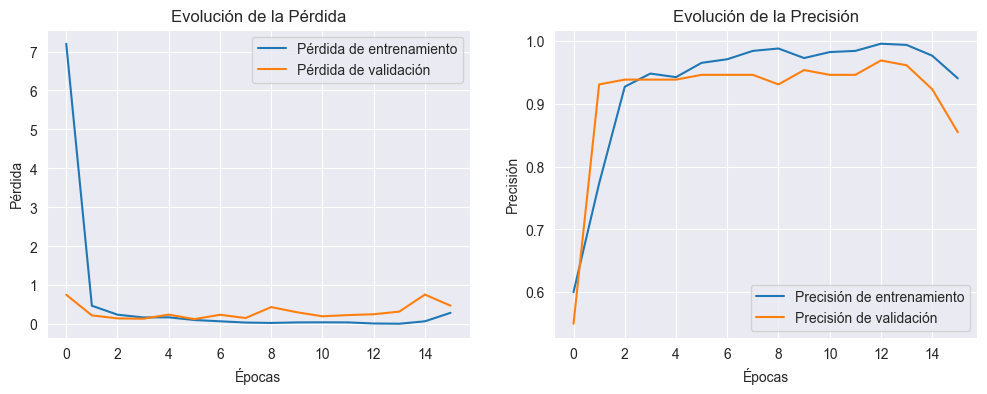

In [17]:
# Evaluación del modelo en el conjunto de test
loss, accuracy = model.evaluate(test_Y)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")
# Visualización de la evolución del entrenamiento
# Extraer los valores del historial
epochs_range = range(len(history.history['loss']))
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Pérdida de entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Evolución de la Pérdida')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Precisión de entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Evolución de la Precisión')
plt.show()


### 6. Uso del modelo en predicciones

In [18]:
# Hacer las predicciones sobre el conjunto de prueba
predictions = model.predict(test_dataset)

# Convertir las predicciones en clases binarias
predicted_classes = (predictions > 0.5).astype(np.float32).flatten()

# Verificar las formas
# print(f"test_Y shape: {test_dataset.shape}")  # Usar labels en test_dataset
print(f"predicted_classes shape: {predicted_classes.shape}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
predicted_classes shape: (160,)


In [19]:
target_names = ["mascarilla", "no_mascarilla"]

# Hacer las predicciones sobre el conjunto de prueba
predictions = model.predict(test_dataset)

# Convertir las predicciones en clases binarias
predicted_classes = (predictions > 0.5).astype(np.float32).flatten()

# Obtener las etiquetas reales
true_labels = []
for _, labels in test_dataset:
    true_labels.append(labels)
true_labels = np.concatenate(true_labels)  # Convertir a array de NumPy

# Verificar las formas
print(f"true_labels shape: {true_labels.shape}")
print(f"predicted_classes shape: {predicted_classes.shape}")

# Mostrar el classification_report
print(classification_report(true_labels, predicted_classes, target_names=target_names))


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
true_labels shape: (160, 1)
predicted_classes shape: (160,)
               precision    recall  f1-score   support

   mascarilla       0.41      0.41      0.41        80
no_mascarilla       0.41      0.41      0.41        80

     accuracy                           0.41       160
    macro avg       0.41      0.41      0.41       160
 weighted avg       0.41      0.41      0.41       160



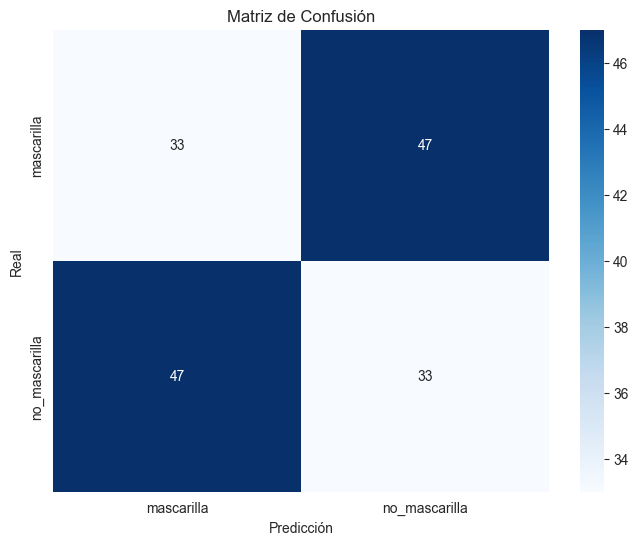

In [20]:
# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Etiquetas correctas para las 10 clases
target_names = ["mascarilla", "no_mascarilla"]

# Mostrar matriz de confusión con heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()